In [2]:
# Load the provided CSV file to examine its contents and structure.
import pandas as pd

# Load the CSV file
csv_path = '/Users/rajbehera/Documents/college docs/machine learning/final project/meta/esc50.csv'
esc50_data = pd.read_csv(csv_path)

# Display the first few rows of the dataframe to understand its structure
esc50_data.head()


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


All recordings loaded.
Average accuracy: 42.9%
Confusion Matrix (ESC-50, Random Forest):
[[20  0  0 ...  0  0  2]
 [ 1  4  1 ...  0  0  0]
 [ 0  0 24 ...  0  3  0]
 ...
 [ 0  0  0 ... 12  0  4]
 [ 0  0  0 ...  0  7  1]
 [ 4  0  0 ...  6  1 15]]


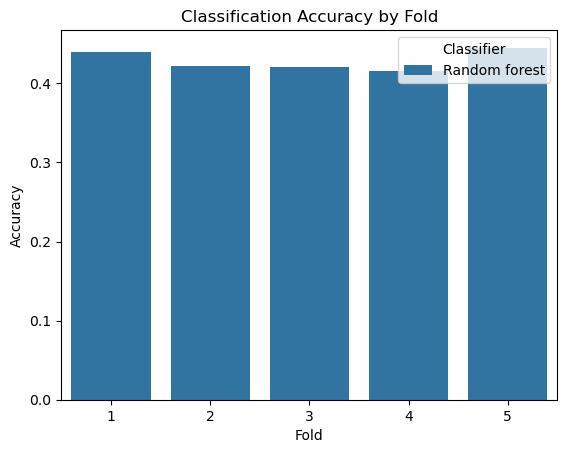

In [3]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Load the metadata from the CSV file
csv_path = '/Users/rajbehera/Documents/college docs/machine learning/final project/meta/esc50.csv'
esc50_data = pd.read_csv(csv_path)

# Path to the directory containing the audio files
audio_dir = '/Users/rajbehera/Documents/college docs/machine learning/final project/audio'

# Helper class for loading recordings and computing baseline features
class Clip:
    RATE = 44100
    FRAME = 512
    
    class Audio:
        def __init__(self, path):
            self.path = path
        
        def __enter__(self):
            self.data, _ = librosa.load(self.path, sr=Clip.RATE, duration=5.0)
            return self
        
        def __exit__(self, exception_type, exception_value, traceback):
            del self.data
    
    def __init__(self, filename, category):
        self.filename = filename
        self.path = os.path.join(audio_dir, filename)
        self.category = category
        self.audio = Clip.Audio(self.path)
        with self.audio as audio:
            self._compute_mfcc(audio)
            self._compute_zcr(audio)
            
    def _compute_mfcc(self, audio):
        self.melspectrogram = librosa.feature.melspectrogram(y=audio.data, sr=Clip.RATE, hop_length=Clip.FRAME)
        self.logamplitude = librosa.amplitude_to_db(self.melspectrogram)
        self.mfcc = librosa.feature.mfcc(S=self.logamplitude, sr=Clip.RATE, n_mfcc=13).T
            
    def _compute_zcr(self, audio):
        self.zcr = librosa.feature.zero_crossing_rate(y=audio.data, frame_length=Clip.FRAME, hop_length=Clip.FRAME)[0]
    
    def __repr__(self):
        return f'<{self.category}/{self.filename}>'

# Function to load the dataset
def load_dataset(metadata):
    clips = []
    for _, row in metadata.iterrows():
        clip = Clip(row['filename'], row['category'])
        clips.append(clip)
    print('All recordings loaded.')
    return clips

clips_50 = load_dataset(esc50_data)

# Function to create a set of features
def create_set(clips):
    cases_list = []
    for clip in clips:
        case = pd.DataFrame([clip.filename], columns=['filename'])
        case['category'] = clip.category
        case['fold'] = int(clip.filename.split('-')[0])
        mfcc_mean = pd.DataFrame(np.mean(clip.mfcc[:, 1:], axis=0)).T
        mfcc_mean.columns = [f'MFCC_{i} mean' for i in range(1, np.shape(clip.mfcc)[1])]
        mfcc_std = pd.DataFrame(np.std(clip.mfcc[:, 1:], axis=0)).T
        mfcc_std.columns = [f'MFCC_{i} std dev' for i in range(1, np.shape(clip.mfcc)[1])]
        case = case.join(mfcc_mean)
        case = case.join(mfcc_std)
        case['ZCR mean'] = np.mean(clip.zcr)
        case['ZCR std dev'] = np.std(clip.zcr)
        cases_list.append(case)
    cases = pd.concat(cases_list, ignore_index=True)
    cases['fold'] = cases['fold'].astype(int)
    return cases

cases_50 = create_set(clips_50)

# Classification function
def classify(cases, classifier='knn'):
    results = []
    class_count = len(cases['category'].unique())
    confusion = np.zeros((class_count, class_count), dtype=int)
    
    for fold in range(1, 6):
        train = cases[cases['fold'] != fold].copy()
        test = cases[cases['fold'] == fold].copy()
        if classifier == 'knn':
            model = KNeighborsClassifier(n_neighbors=8)
        elif classifier == 'rf':
            model = RandomForestClassifier(n_estimators=500, random_state=42)
        elif classifier == 'svm':
            model = SVC(C=0.1, kernel='linear', random_state=42)
        model.fit(train.iloc[:, 3:], train['category'])
        test['prediction'] = model.predict(test.iloc[:, 3:])
        accuracy = np.sum(test['category'] == test['prediction']) / float(len(test['category']))
        results.append(accuracy)
        confusion += confusion_matrix(test['category'], test['prediction'])
    
    print(f'Average accuracy: {np.mean(results) * 100:.1f}%')
    return confusion, results

# Running classification on ESC-50 dataset
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf')
print('Confusion Matrix (ESC-50, Random Forest):')
print(confusion_50_rf)

# Plotting accuracy results
def plot_accuracy_folds(rf_50):
    folds_50 = [str(i) for i in range(1, 6)]
    accuracy = pd.DataFrame({'Fold': folds_50, 'Accuracy': rf_50, 'Classifier': 'Random forest'})
    
    sb.barplot(x='Fold', y='Accuracy', hue='Classifier', data=accuracy)
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.title('Classification Accuracy by Fold')
    plt.show()

plot_accuracy_folds(accuracy_50_rf)


/Users/rajbehera/anaconda3/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


All recordings loaded.
Shape of X: (2000, 306)
Shape of y: (2000,)
Categories: ['airplane' 'breathing' 'brushing_teeth' 'can_opening' 'car_horn' 'cat'
 'chainsaw' 'chirping_birds' 'church_bells' 'clapping' 'clock_alarm'
 'clock_tick' 'coughing' 'cow' 'crackling_fire' 'crickets' 'crow'
 'crying_baby' 'dog' 'door_wood_creaks' 'door_wood_knock'
 'drinking_sipping' 'engine' 'fireworks' 'footsteps' 'frog'
 'glass_breaking' 'hand_saw' 'helicopter' 'hen' 'insects'
 'keyboard_typing' 'laughing' 'mouse_click' 'pig' 'pouring_water' 'rain'
 'rooster' 'sea_waves' 'sheep' 'siren' 'sneezing' 'snoring' 'thunderstorm'
 'toilet_flush' 'train' 'vacuum_cleaner' 'washing_machine' 'water_drops'
 'wind']
Processing fold 1
Accuracy for fold 1: 23.5%
Processing fold 2
Accuracy for fold 2: 21.8%
Processing fold 3
Accuracy for fold 3: 28.2%
Processing fold 4
Accuracy for fold 4: 29.2%
Processing fold 5
Accuracy for fold 5: 21.0%
Average accuracy for knn: 24.7%
Processing fold 1
Accuracy for fold 1: 43.5%
Proces

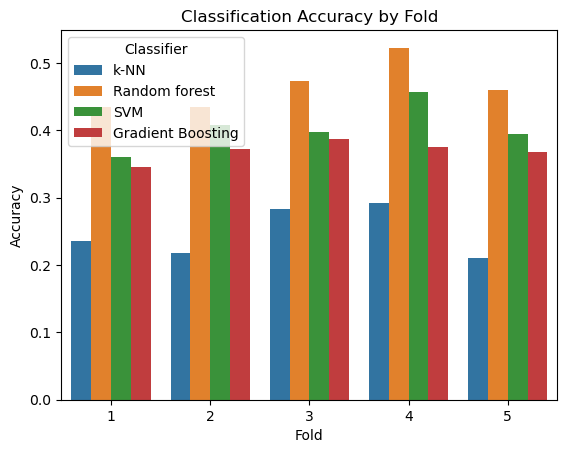

In [4]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Load the metadata from the CSV file
csv_path = '/Users/rajbehera/Documents/college docs/machine learning/final project/meta/esc50.csv'
esc50_data = pd.read_csv(csv_path)

# Path to the directory containing the audio files
audio_dir = '/Users/rajbehera/Documents/college docs/machine learning/final project/audio'

# Helper class for loading recordings and computing baseline features
class Clip:
    RATE = 44100
    FRAME = 512
    
    class Audio:
        def __init__(self, path):
            self.path = path
        
        def __enter__(self):
            self.data, _ = librosa.load(self.path, sr=Clip.RATE, duration=5.0)
            return self
        
        def __exit__(self, exception_type, exception_value, traceback):
            del self.data
    
    def __init__(self, filename, category):
        self.filename = filename
        self.path = os.path.join(audio_dir, filename)
        self.category = category
        self.audio = Clip.Audio(self.path)
        with self.audio as audio:
            self._compute_features(audio)
            
    def _compute_features(self, audio):
        self.mfcc = librosa.feature.mfcc(y=audio.data, sr=Clip.RATE, n_mfcc=13).T
        self.chroma = librosa.feature.chroma_stft(y=audio.data, sr=Clip.RATE).T
        self.melspectrogram = librosa.feature.melspectrogram(y=audio.data, sr=Clip.RATE).T
            
    def __repr__(self):
        return f'<{self.category}/{self.filename}>'

# Function to load the dataset
def load_dataset(metadata):
    clips = []
    for _, row in metadata.iterrows():
        clip = Clip(row['filename'], row['category'])
        clips.append(clip)
    print('All recordings loaded.')
    return clips

clips_50 = load_dataset(esc50_data)

# Function to create a set of features
def create_set(clips):
    cases_list = []
    for clip in clips:
        case = pd.DataFrame([clip.filename], columns=['filename'])
        case['category'] = clip.category
        case['fold'] = int(clip.filename.split('-')[0])
        
        mfcc_mean = pd.DataFrame(np.mean(clip.mfcc, axis=0)).T
        mfcc_mean.columns = [f'MFCC_{i} mean' for i in range(np.shape(clip.mfcc)[1])]
        mfcc_std = pd.DataFrame(np.std(clip.mfcc, axis=0)).T
        mfcc_std.columns = [f'MFCC_{i} std dev' for i in range(np.shape(clip.mfcc)[1])]
        
        chroma_mean = pd.DataFrame(np.mean(clip.chroma, axis=0)).T
        chroma_mean.columns = [f'Chroma_{i} mean' for i in range(np.shape(clip.chroma)[1])]
        chroma_std = pd.DataFrame(np.std(clip.chroma, axis=0)).T
        chroma_std.columns = [f'Chroma_{i} std dev' for i in range(np.shape(clip.chroma)[1])]
        
        mel_mean = pd.DataFrame(np.mean(clip.melspectrogram, axis=0)).T
        mel_mean.columns = [f'Mel_{i} mean' for i in range(np.shape(clip.melspectrogram)[1])]
        mel_std = pd.DataFrame(np.std(clip.melspectrogram, axis=0)).T
        mel_std.columns = [f'Mel_{i} std dev' for i in range(np.shape(clip.melspectrogram)[1])]
        
        case = case.join(mfcc_mean)
        case = case.join(mfcc_std)
        case = case.join(chroma_mean)
        case = case.join(chroma_std)
        case = case.join(mel_mean)
        case = case.join(mel_std)
        
        cases_list.append(case)
    cases = pd.concat(cases_list, ignore_index=True)
    cases['fold'] = cases['fold'].astype(int)
    return cases

cases_50 = create_set(clips_50)

# Ensure the features are in the correct format
X = cases_50.iloc[:, 3:].values
y = cases_50['category'].values

# Ensure the input data is numpy array
X = np.asarray(X)
y = np.asarray(y)

# Debug prints
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"Categories: {np.unique(y)}")

# Classification function
def classify(cases, classifier):
    results = []
    class_count = len(cases['category'].unique())
    confusion = np.zeros((class_count, class_count), dtype=int)
    
    for fold in range(1, 6):
        print(f"Processing fold {fold}")
        train = cases[cases['fold'] != fold].copy()
        test = cases[cases['fold'] == fold].copy()
        train_X = np.asarray(train.iloc[:, 3:])
        test_X = np.asarray(test.iloc[:, 3:])
        train_y = np.asarray(train['category'])
        test_y = np.asarray(test['category'])
        
        if classifier == 'knn':
            model = KNeighborsClassifier(n_neighbors=8)
        elif classifier == 'rf':
            model = RandomForestClassifier(n_estimators=100, random_state=42)  # Reduced n_estimators
        elif classifier == 'svm':
            model = SVC(C=0.1, kernel='linear', random_state=42)
        elif classifier == 'gb':
            model = GradientBoostingClassifier(n_estimators=100, random_state=42)  # Reduced n_estimators
        
        model.fit(train_X, train_y)
        test['prediction'] = model.predict(test_X)
        accuracy = np.sum(test_y == test['prediction']) / float(len(test_y))
        results.append(accuracy)
        confusion += confusion_matrix(test_y, test['prediction'])
        print(f"Accuracy for fold {fold}: {accuracy * 100:.1f}%")
    
    print(f'Average accuracy for {classifier}: {np.mean(results) * 100:.1f}%')
    return confusion, results

# Running classification on ESC-50 dataset using different classifiers
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm')
confusion_50_gb, accuracy_50_gb = classify(cases_50, 'gb')

print('Confusion Matrix (ESC-50, k-NN):')
print(confusion_50_knn)
print('Confusion Matrix (ESC-50, Random Forest):')
print(confusion_50_rf)
print('Confusion Matrix (ESC-50, SVM):')
print(confusion_50_svm)
print('Confusion Matrix (ESC-50, Gradient Boosting):')
print(confusion_50_gb)

# Plotting accuracy results
def plot_accuracy_folds(knn_50, rf_50, svm_50, gb_50):
    folds_50 = [str(i) for i in range(1, 6)]
    accuracy = pd.DataFrame({
        'Fold': folds_50,
        'k-NN': knn_50,
        'Random forest': rf_50,
        'SVM': svm_50,
        'Gradient Boosting': gb_50
    })
    
    accuracy = pd.melt(accuracy, id_vars='Fold', var_name='Classifier', value_name='Accuracy')
    
    sb.barplot(x='Fold', y='Accuracy', hue='Classifier', data=accuracy)
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.title('Classification Accuracy by Fold')
    plt.show()

plot_accuracy_folds(accuracy_50_knn, accuracy_50_rf, accuracy_50_svm, accuracy_50_gb)


/Users/rajbehera/anaconda3/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


All recordings loaded.
Shape of X: (2000, 306)
Shape of y: (2000,)
Categories: ['airplane' 'breathing' 'brushing_teeth' 'can_opening' 'car_horn' 'cat'
 'chainsaw' 'chirping_birds' 'church_bells' 'clapping' 'clock_alarm'
 'clock_tick' 'coughing' 'cow' 'crackling_fire' 'crickets' 'crow'
 'crying_baby' 'dog' 'door_wood_creaks' 'door_wood_knock'
 'drinking_sipping' 'engine' 'fireworks' 'footsteps' 'frog'
 'glass_breaking' 'hand_saw' 'helicopter' 'hen' 'insects'
 'keyboard_typing' 'laughing' 'mouse_click' 'pig' 'pouring_water' 'rain'
 'rooster' 'sea_waves' 'sheep' 'siren' 'sneezing' 'snoring' 'thunderstorm'
 'toilet_flush' 'train' 'vacuum_cleaner' 'washing_machine' 'water_drops'
 'wind']
Processing fold 1


/Users/rajbehera/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for fold 1: 36.5%
Processing fold 2


/Users/rajbehera/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for fold 2: 33.2%
Processing fold 3


/Users/rajbehera/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for fold 3: 34.5%
Processing fold 4


/Users/rajbehera/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for fold 4: 39.5%
Processing fold 5


/Users/rajbehera/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for fold 5: 35.5%
Average accuracy for lr: 35.9%
Processing fold 1
Accuracy for fold 1: 22.5%
Processing fold 2
Accuracy for fold 2: 24.0%
Processing fold 3
Accuracy for fold 3: 25.0%
Processing fold 4
Accuracy for fold 4: 27.3%
Processing fold 5
Accuracy for fold 5: 25.5%
Average accuracy for dt: 24.9%
Confusion Matrix (ESC-50, Logistic Regression):
[[15  0  0 ...  2  0  3]
 [ 1 12  0 ...  0  1  0]
 [ 0  0 21 ...  1  0  0]
 ...
 [ 3  0  0 ... 11  0  2]
 [ 0  0  0 ...  0 10  0]
 [ 2  1  0 ...  2  0 13]]
Confusion Matrix (ESC-50, Decision Tree):
[[14  0  0 ...  1  0  3]
 [ 0  3  3 ...  0  4  0]
 [ 0  1 13 ...  1  0  0]
 ...
 [ 0  0  1 ...  4  0  5]
 [ 0  1  1 ...  0  6  0]
 [ 2  0  0 ...  5  0 10]]


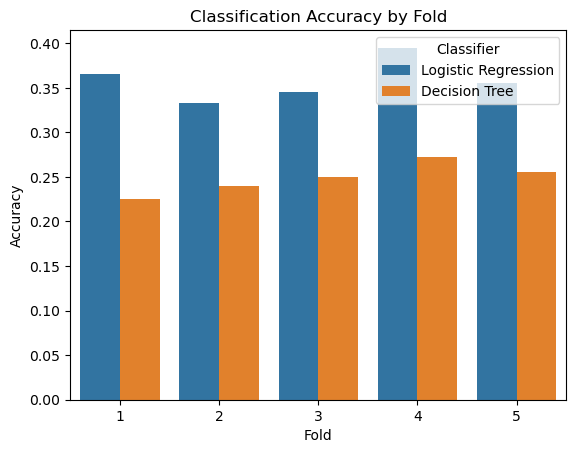

In [5]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Load the metadata from the CSV file
csv_path = '/Users/rajbehera/Documents/college docs/machine learning/final project/meta/esc50.csv'
esc50_data = pd.read_csv(csv_path)

# Path to the directory containing the audio files
audio_dir = '/Users/rajbehera/Documents/college docs/machine learning/final project/audio'

# Helper class for loading recordings and computing baseline features
class Clip:
    RATE = 44100
    FRAME = 512
    
    class Audio:
        def __init__(self, path):
            self.path = path
        
        def __enter__(self):
            self.data, _ = librosa.load(self.path, sr=Clip.RATE, duration=5.0)
            return self
        
        def __exit__(self, exception_type, exception_value, traceback):
            del self.data
    
    def __init__(self, filename, category):
        self.filename = filename
        self.path = os.path.join(audio_dir, filename)
        self.category = category
        self.audio = Clip.Audio(self.path)
        with self.audio as audio:
            self._compute_features(audio)
            
    def _compute_features(self, audio):
        self.mfcc = librosa.feature.mfcc(y=audio.data, sr=Clip.RATE, n_mfcc=13).T
        self.chroma = librosa.feature.chroma_stft(y=audio.data, sr=Clip.RATE).T
        self.melspectrogram = librosa.feature.melspectrogram(y=audio.data, sr=Clip.RATE).T
            
    def __repr__(self):
        return f'<{self.category}/{self.filename}>'

# Function to load the dataset
def load_dataset(metadata):
    clips = []
    for _, row in metadata.iterrows():
        clip = Clip(row['filename'], row['category'])
        clips.append(clip)
    print('All recordings loaded.')
    return clips

clips_50 = load_dataset(esc50_data)

# Function to create a set of features
def create_set(clips):
    cases_list = []
    for clip in clips:
        case = pd.DataFrame([clip.filename], columns=['filename'])
        case['category'] = clip.category
        case['fold'] = int(clip.filename.split('-')[0])
        
        mfcc_mean = pd.DataFrame(np.mean(clip.mfcc, axis=0)).T
        mfcc_mean.columns = [f'MFCC_{i} mean' for i in range(np.shape(clip.mfcc)[1])]
        mfcc_std = pd.DataFrame(np.std(clip.mfcc, axis=0)).T
        mfcc_std.columns = [f'MFCC_{i} std dev' for i in range(np.shape(clip.mfcc)[1])]
        
        chroma_mean = pd.DataFrame(np.mean(clip.chroma, axis=0)).T
        chroma_mean.columns = [f'Chroma_{i} mean' for i in range(np.shape(clip.chroma)[1])]
        chroma_std = pd.DataFrame(np.std(clip.chroma, axis=0)).T
        chroma_std.columns = [f'Chroma_{i} std dev' for i in range(np.shape(clip.chroma)[1])]
        
        mel_mean = pd.DataFrame(np.mean(clip.melspectrogram, axis=0)).T
        mel_mean.columns = [f'Mel_{i} mean' for i in range(np.shape(clip.melspectrogram)[1])]
        mel_std = pd.DataFrame(np.std(clip.melspectrogram, axis=0)).T
        mel_std.columns = [f'Mel_{i} std dev' for i in range(np.shape(clip.melspectrogram)[1])]
        
        case = case.join(mfcc_mean)
        case = case.join(mfcc_std)
        case = case.join(chroma_mean)
        case = case.join(chroma_std)
        case = case.join(mel_mean)
        case = case.join(mel_std)
        
        cases_list.append(case)
    cases = pd.concat(cases_list, ignore_index=True)
    cases['fold'] = cases['fold'].astype(int)
    return cases

cases_50 = create_set(clips_50)

# Ensure the features are in the correct format
X = cases_50.iloc[:, 3:].values
y = cases_50['category'].values

# Ensure the input data is numpy array
X = np.asarray(X)
y = np.asarray(y)

# Debug prints
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"Categories: {np.unique(y)}")

# Classification function
def classify(cases, classifier):
    results = []
    class_count = len(cases['category'].unique())
    confusion = np.zeros((class_count, class_count), dtype=int)
    
    for fold in range(1, 6):
        print(f"Processing fold {fold}")
        train = cases[cases['fold'] != fold].copy()
        test = cases[cases['fold'] == fold].copy()
        train_X = np.asarray(train.iloc[:, 3:])
        test_X = np.asarray(test.iloc[:, 3:])
        train_y = np.asarray(train['category'])
        test_y = np.asarray(test['category'])
        
        if classifier == 'lr':
            model = LogisticRegression(max_iter=1000, random_state=42)
        elif classifier == 'dt':
            model = DecisionTreeClassifier(random_state=42)
        
        model.fit(train_X, train_y)
        test['prediction'] = model.predict(test_X)
        accuracy = np.sum(test_y == test['prediction']) / float(len(test_y))
        results.append(accuracy)
        confusion += confusion_matrix(test_y, test['prediction'])
        print(f"Accuracy for fold {fold}: {accuracy * 100:.1f}%")
    
    print(f'Average accuracy for {classifier}: {np.mean(results) * 100:.1f}%')
    return confusion, results

# Running classification on ESC-50 dataset using Logistic Regression and Decision Tree
confusion_50_lr, accuracy_50_lr = classify(cases_50, 'lr')
confusion_50_dt, accuracy_50_dt = classify(cases_50, 'dt')

print('Confusion Matrix (ESC-50, Logistic Regression):')
print(confusion_50_lr)
print('Confusion Matrix (ESC-50, Decision Tree):')
print(confusion_50_dt)

# Plotting accuracy results
def plot_accuracy_folds(lr_50, dt_50):
    folds_50 = [str(i) for i in range(1, 6)]
    accuracy = pd.DataFrame({
        'Fold': folds_50,
        'Logistic Regression': lr_50,
        'Decision Tree': dt_50
    })
    
    accuracy = pd.melt(accuracy, id_vars='Fold', var_name='Classifier', value_name='Accuracy')
    
    sb.barplot(x='Fold', y='Accuracy', hue='Classifier', data=accuracy)
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.title('Classification Accuracy by Fold')
    plt.show()

plot_accuracy_folds(accuracy_50_lr, accuracy_50_dt)
